## **Controlled probabilistic ordering**

Currently, if we don’t input a fixed order **(CHECK fixed_ordering.ipynb)**, the experiments definition takes the probabilities of the n stimuli and randomly decides it. 

**What if we want to guarantee that certain stimuli always occur after another stimuli?** For example, what if don't want to neccesarily fix the order, but we want to make sure stimuli 1 always occurs before stimuli 2. We need to create a relation that will generate an order that satisfies this criteria.

The idea is to define a new function that takes the **stimuli as sequences** with a probability for each sequence occurring.

##### **`sample_from_probabilities(self, prob, key, length)`** (Experiment class)

Generates an experimental order by sampling from the provided keys (sequences of stimuli) based on their assigned probabilities.

#### **Sequence Generation Variables**
*The following three variables are used to generate an order with keys (sequences). They are inputs for the `sample_from_probabilities` function.*

* **`order_keys`** `(list of integer lists)`
    * The list of sequences corresponding to stimuli/stimuli ordering.
* **`order_probabilities`** `(list of floats)`
    * Defines the probability of the corresponding sequences (must sum to 1).
* **`order_length`** `(int)`
    * The number of times we want to select from the `order_keys` based on the `order_probabilities`.

Here is the function's implementation for visualization

```python
#Generates an order based on a given probability distribution of certain keys
def sample_from_probabilities(self, prob, key, length):
    # random.choices picks elements from key with weights = prob_array\
    samples = random.choices(key, weights=prob, k=length)
    merged = [item for sublist in samples for item in sublist]
    return merged
```


### **Example**

Here will we show how to add the probabilistic ordering into simulation.

Suppose we have **4 stimuli** in our experiment labeled 0, 1, 2, 3. We want to control our ordering such that stimuli 2 always follows stimuli 1, and stimuli 3 always follows stimuli 2. 

This tells us that any time stimuli 1 occurs, the entire sequence [1, 2, 3] of stimulis occurs. On the other hand, there is no relation with 0, so [0] is a sequence of its own.

Let's say we want stimuli 0 to occur around as frequently as stimuli's 1,2,3. Thus, the probability of each sequence is 0.5, leaving us with the following parameters:

    order_keys = [[0], [1,2,3]]
    order_probabilities = [0.5, 0.5]

**Note:** The indices of sequence to probability must match!

In [13]:
import numpy as np
import neurodesign
import matplotlib.pyplot as plt

In [14]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [15]:
#Random Order:
probabilities = [0.5, 0.5]
keys = [[0], [1,2,3]]

In [16]:
exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=0.5,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=2,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.5,                # Mean ITI
    order_probabilities=probabilities,
    order_keys=keys,
    order_length=20,
)

In [17]:
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

In [18]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Ff (estimation efficiency): {best_design.Ff}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Fe (stimulus frequency balance): {best_design.Fe}")

Fd (detection efficiency): 1.3343853281226936
Ff (estimation efficiency): 1.0
Fc (confounding): 0.4788087056128293
Fe (stimulus frequency balance): 0


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.19859016e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.24333304e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.08746121e-01  5.41264075e-04  0.00000000e+00]
 [ 0.00000000e+00  1.50213325e-01  7.69440571e-02  0.00000000e+00]
 [ 0.00000000e+00  6.76055106e-02  2.01775345e-01  0.00000000e+00]
 [ 0.00000000e+00  1.55838951e-02  1.75550780e-01  8.93409566e-06]
 [ 0.00000000e+00 -9.52423913e-03  8.98447040e-02  4.19453804e-02]
 [ 0.00000000e+00 -1.81410132e-02  2.78206768e-02  1.83234327e-01]
 [ 5.41264075e-04 -1.74079719e-02 -4.12308805e-03  1.93193102e-01]
 [ 7.69440571e-02 -1.27355940e-02 -1.68193717e-02  1.10479524e-01]
 [ 2.01775345e-01 -7.76974767e-03 -1.82599606e-02  4.01180356e-02]
 [ 1.75550780e-01  3.19275864e-02 -1.42930233e-02  1.66443820e-03]
 [ 8.98447040e-02  1.76203447e-01 -9.16013865e-03 -1.49604368e-02]
 [ 2.78206768e-02  1.95278914e-01  8.70784874e-03 -1.86120841e

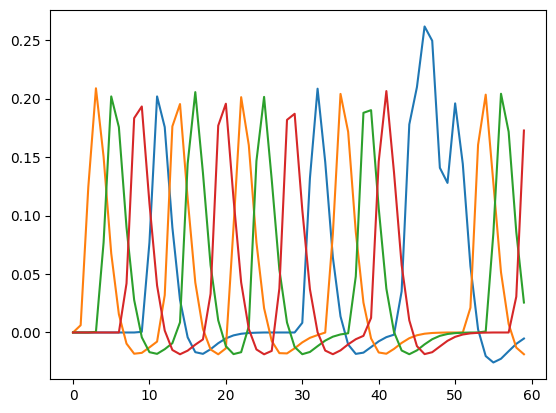

In [19]:
# Compute the convolved bestdesign matrix and evaluate design quality
best_design.designmatrix()
print(best_design.Xconv)
plt.plot(best_design.Xconv)

Notice how **we either have a [0] or [1,2,3] in a pattern**, showing that are controlled ordering is satisfied. Morever we can a relatively similar number of stimuli 0 peaks and stimulis 1,2,3 peaks if your run the code multiple times. 

Note: since it is a probability based order generation, the ratio may vary on each run.